# Horn Schunck Optical Flow
Filipe Barnabé - \
João Ferreira - \
Xavier Verbrugge - 

## Necessary librarires

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## First approaches to the images (import -> resize)
Since opencv imports images as BGR it is necessary to also convert the images into a gray scale. \
The images (arrays) are converted to float for future work

In [2]:
# Important parameters:
multi_channel = True

In [3]:
def images(path: str, multi_channel: bool, resize_percentage: int = 50) -> np.ndarray:
    img = cv.imread(path)
    if not multi_channel:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = img.astype(np.float32)
    else:
        for i in range(img.shape[2]):
            img[:,:,i] = img[:,:,i].astype(np.float32)
    width = int(img.shape[1] * resize_percentage/100)
    height = int(img.shape[0] * resize_percentage/100)
    img = cv.resize(img, (width, height), interpolation=cv.INTER_AREA)
    
    return img

In [4]:
# gray images
multi_channel = False
img1 = images(path="dataset/eval-data-gray/Army/frame07.png", multi_channel=multi_channel)
img2 = images(path="dataset/eval-data-gray/Army/frame08.png", multi_channel=multi_channel)

In [5]:
# color images
multi_channel = True
img3 = images(path="dataset/eval-data/Army/frame07.png", multi_channel=multi_channel)
img4 = images(path="dataset/eval-data/Army/frame08.png", multi_channel=multi_channel)

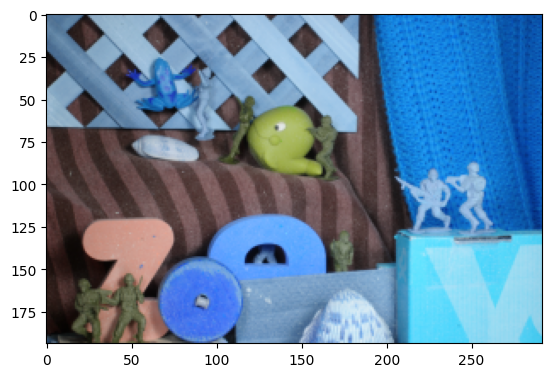

In [6]:
# img3 = cv.imread("dataset/eval-data/Army/frame07.png")
plt.imshow(img3)


In [7]:
img3.shape

(194, 292, 3)

## Defenition of the masks

maskX = 
$\begin{bmatrix}
-1 & 1\\
-1 & 1
\end{bmatrix}$ 

maskY = 
$\begin{bmatrix}
1 & 1\\
-1 & -1
\end{bmatrix}$ 

maskT = 
$\begin{bmatrix} 
1 & 1\\
1 & 1
\end{bmatrix}$

**Laplacian Mask**

maksHS = 
$\begin{bmatrix} 
\frac{1}{12} & \frac{1}{6} & \frac{1}{12}\\[6pt]
\frac{1}{6} & -1 & \frac{1}{6}\\[6pt]
\frac{1}{12} & \frac{1}{6} & \frac{1}{12}
\end{bmatrix}$

In [8]:
# Laplace kernel 
hs_kernel = np.array(
    [[1 / 12, 1 / 6, 1 / 12], [1 / 6, 0, 1 / 6], [1 / 12, 1 / 6, 1 / 12]], float
)
# X, Y, T kernel
kernelX = np.array([[-1,1],[-1,1]]) * 0.25
kernelY = np.array([[1,1],[-1,-1]]) * 0.25
kernelT = np.ones((2,2)) * 0.25

In [9]:
# Derivatives computation
def derivatives_computation(img1: np.ndarray, img2: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    fx = cv.filter2D(img1, -1, cv.flip(kernelX, -1), borderType=cv.BORDER_CONSTANT) + \
        cv.filter2D(img2, -1, cv.flip(kernelX, -1), borderType=cv.BORDER_CONSTANT)
    fy = cv.filter2D(img1, -1, cv.flip(kernelY, -1), borderType=cv.BORDER_CONSTANT) + \
        cv.filter2D(img2, -1, cv.flip(kernelY, -1), borderType=cv.BORDER_CONSTANT)
    ft = cv.filter2D(img1, -1, cv.flip(kernelT, -1), borderType=cv.BORDER_CONSTANT) + \
        cv.filter2D(img2, -1, cv.flip(-kernelT, -1), borderType=cv.BORDER_CONSTANT)
    
    return fx, fy, ft

In [10]:
def sigle_multi_channel_derivatives(multi_channel: bool, img1:np.ndarray, img2= np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    if multi_channel:
        fx, fy, ft = [np.zeros(shape=(img1.shape[0], img1.shape[1])) for _ in range(3)] 
        for i in range(img1.shape[2]):
            [fx_c, fy_c, ft_c] = derivatives_computation(img1=img1[:,:,i], img2=img2[:,:,i])
            fx = fx + fx_c
            fy = fy + fy_c
            ft = ft + ft_c
    else:
        [fx, fy, ft] = derivatives_computation(img1=img1, img2=img2)
    return fx, fy, ft

In [11]:
[fx, fy, ft] = sigle_multi_channel_derivatives(multi_channel, img1=img3, img2=img4)

In [12]:
# [fx, fy, ft] = derivatives_computation(img1=img1, img2=img2)

In [13]:
# Initialize the velocities as zeros (u and v)
images_shape = img3.shape
u = np.zeros(shape=(images_shape[0], images_shape[1]), dtype=np.float32)
v = np.zeros(shape=(images_shape[0], images_shape[1]), dtype=np.float32)

In [14]:
alpha = 0.001
for _ in range(1000):
    # Computation of the local average
    uAvg = cv.filter2D(u, -1, cv.flip(hs_kernel, -1), borderType=cv.BORDER_CONSTANT)
    vAvg = cv.filter2D(v, -1, cv.flip(hs_kernel, -1), borderType=cv.BORDER_CONSTANT)

    der = (fx * uAvg + fy * vAvg + ft) / (alpha ** 2 + fx ** 2 + fy ** 2)

    u = uAvg - fx * der
    v = vAvg - fy * der

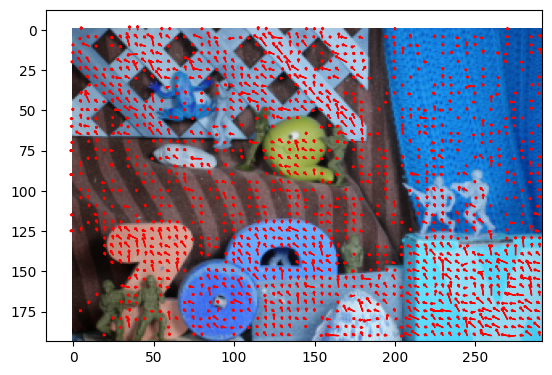

In [15]:
quivstep = 5
scale = 0.01
fn = None
ax = plt.figure().gca()
ax.imshow(img3, cmap="gray", origin="upper")

# plt.scatter(POI[:,0,1],POI[:,0,0])
for i in range(0, u.shape[0], quivstep):
    for j in range(0, v.shape[1], quivstep):
        arrow = np.sqrt(u[i,j]**2+v[i,j]**2)
        if arrow > 50:
            ax.arrow(
                j,
                i,
                v[i, j] * scale,
                u[i, j] * scale,
                color="red",
                head_width=1.5,
                head_length=1,
            )

plt.draw()
plt.pause(0.01)

In [ ]:
teste=1